In [1]:
URL = "localhost:5432"
BUCKET_ID =  853
DATA_FILE = f"joined{BUCKET_ID}"
DATA_PATH = f'./data/{DATA_FILE}'


# Setup


In [2]:
import pandas as pd
import numpy as np
import graph_tool.all as gt
from sqlalchemy import create_engine
import re
from tqdm import tqdm


In [3]:
try:
    ev = pd.read_feather(DATA_PATH + '.feather')
except FileNotFoundError:
    db = create_engine(
        f"postgresql://postgres:password@{URL}/debate-cards").connect()
    ev = pd.read_sql("""
      SELECT id, gid, tag, cite, fullcite, fulltext, markup, pocket, hat, block, "fileId" FROM public."Evidence" 
      WHERE "bucketId" = {0};
    """.format(BUCKET_ID), db)
    print("Loaded from database")

    SENTENCE_REGEX = r'[.?!]+(?=\d*\s+[a-zA-Z])'
    cutoff = 20
    ev['sentences'] = ev.fulltext.str \
        .split(SENTENCE_REGEX) \
        .map(lambda l: list(map(lambda s: re.sub(r'[^a-zA-Z]', '', s), l))) \
        .map(lambda l: list(filter(lambda s: len(s) >= cutoff, l)))
    print("Sentences added")

    ev.to_feather(DATA_PATH + '.feather')


Utility function to display list of cards as HTML

In [4]:
from IPython.display import HTML
parentStyles = """
  margin: 50px; 
  height: 500px; 
  display: flex;
  overflow-x: scroll;
"""
childStyles = """"
  padding: 10px;
  flex-shrink: 0;
  flex-basis: 200px;
  overflow: scroll;
"""


def showCards(cards: pd.DataFrame, showIds = False, fileName=None):
    markups = cards.to_dict()['markup'].values()
    headers = [f"<h2>{id}</h2>" if showIds else "" for id in cards.id]
    divs = "\n".join(
        [f"<div style='{childStyles}'>{headers[i]}{markup}</div>" for i, markup in enumerate(markups)])
    html = HTML(f"<div style='{parentStyles}'>{divs}</div>")
    if fileName is None:
      return html
    
    path = DATA_PATH + fileName + '.html'
    with open(path, 'w') as f:
      f.write(str(html.data))
    return HTML(f"<a href={path}>Open</a>")


# Build incremental


Implementation is probably scuffed and inefficient, but its just a prototype

Initilize global things. `bucketMap` and `sentenceMap` would probably be stored in redis

In [5]:
bucketMap: "dict[int, Bucket]" = {}
processQueue: list[int] = []
sentenceMap = {}
log = []

## Card Matching

Reimplementation of things from main repo

In [6]:
INSIDE_TOLERANCE = 2
EDGE_TOLERANCE = 1

# Should always call as "checkMatch(a, b) or checkMatch(b, a)" so commutivity works
def checkMatch(a, b):
    aLen, aMin, aMax = a
    bLen, bMin, bMax = b
    insideMatch = (aLen > 3 and (aLen - (aMax + 1 - aMin) <= INSIDE_TOLERANCE))
    edgeMatch =  (aMin <= EDGE_TOLERANCE and bLen - bMax <= EDGE_TOLERANCE)
    return insideMatch or edgeMatch

In [7]:
def filterMatches(id: int, cardMatches):
    matching = []
    # Apparently this is needed for decent performance
    aLen = len(ev.loc[id].sentences)
    bLens = [len(s) for s in ev.loc[cardMatches.keys()].sentences]
    
    for i, (matchId, matchingSentences) in enumerate(cardMatches.items()):
        aIndexes = [match['aIndex'] for match in matchingSentences]
        bIndexes = [match['bIndex'] for match in matchingSentences]
        aMin, aMax, bMin, bMax = min(aIndexes), max(
            aIndexes), min(bIndexes), max(bIndexes)
        bLen = bLens[i]
        # bLen = len(ev.loc[matchId].sentences)
        aInfo = (aLen, aMin, aMax)
        bInfo = (bLen, bMin, bMax)
        if (checkMatch(aInfo, bInfo) or checkMatch(bInfo, aInfo)):
            matching.append(matchId)

    return matching

In [8]:
def getMatches(id: int) -> list[int]:
    sentences = ev.loc[id].sentences
    cardMatches = {}
    # Get cards with any sentence and common and record the index of sentences that matched in both cards
    for sentenceI, s in enumerate(sentences):
        sentenceMatches = sentenceMap[s] if s in sentenceMap else []
        for match in sentenceMatches:
            if match['cardId'] == id:
                continue
            if not match['cardId'] in cardMatches:
                cardMatches[match['cardId']] = []
            cardMatches[match['cardId']].append(
                {"aIndex": sentenceI, "bIndex": match['index']})
    return filterMatches(id, cardMatches)


## Buckets

In [9]:
from collections import Counter

# Should be configurable
SHOULD_MATCH = lambda matching, total: matching / total > 0.5
SHOULD_MERGE = lambda matching, total: matching > 5 or matching / total >= 0.2


class Bucket:
    def __init__(self, root: int):
        self.root = root
        self.cards = Counter({root: 1}) # Cards in the bucket, with a count of how many other cards in the bucket they match
        self.matching = Counter() # Cards not in the bucket that match some cards in the bucket, with a count of how many they match
        self.bucketSet = BucketSet([self])
        bucketMap[root] = self
    
    
    @property
    def size(self):
        return len(self.cards)

    def removeCard(self, cardId: int):
        del self.cards[cardId]
        del bucketMap[cardId]
        # Decrement match count for things that had matched this card
        # Storing this would take a ton of work, so its probably best to just recalculate matches
        matches = getMatches(cardId)
        for match in matches:
            counter = self.cards if match in self.cards else self.matching
            if counter[match] <= 1: del counter[match]
            else: counter[match] -= 1

    # Remove cards that no longer belong and update bucketSet
    def resolve(self, updates: list[int], updated=False):
        if len(self.cards) == 0: return updated
        
        updates = [u for u in updates if u in bucketMap] # Filter out things that arent assigned to a bucket
        for id, count in self.cards.items():
            # If card no longer belongs
            if not SHOULD_MATCH(count, self.size):
                # Remove from bucket and send to be reprocessed later, easier than finding new bucket now
                self.removeCard(id)
                processQueue.append(id)
                # Stop looping and restart in case something else now dosent belong
                return self.resolve(updates, updated=True)
        self.bucketSet.resolve()

        # Cards that just moved from below threshold to above
        newMatches = [id for id in updates if SHOULD_MERGE(self.matching[id], self.size)
         and not SHOULD_MERGE(self.matching[id] - 1, self.size)]
        
        newMatchBuckets = set([bucketMap[id] for id in newMatches])
        for bucket in newMatchBuckets:
            # print(self.root, self.bucketSet, bucket.root, bucket.bucketSet)
            if bucket.bucketSet != self.bucketSet and self.bucketSet.shouldAdd(bucket):
                self.bucketSet.merge(bucket.bucketSet)
        return updated

    def addCard(self, cardId: int, matches: list[int]):
        del self.matching[cardId]  # Clear from matches not in bucket
        if cardId in self.cards:
            print(f"Warning: {cardId} already in bucket with root {self.root}")
            return

        matchCount = 1 # Matches self, so start at 1
        for match in matches:
            if match in self.cards:
                matchCount += 1
                self.cards[match] += 1
            else:
                self.matching[match] += 1

        self.cards[cardId] = matchCount
        self.root = min(self.root, cardId)
        bucketMap[cardId] = self

    def addMatches(self, cardId: int, matches: list[int]):
        self.matching[cardId] += len(np.intersect1d(matches, list(self.cards)))

    def bucketMatches(self, matches: list[int]):
      return SHOULD_MATCH(len(np.intersect1d(matches, list(self.cards))), self.size)

    def __repr__(self) -> str:
        return f"Bucket(Root: {self.root}, Size: {self.size}, Cards: {self.cards}, Matching: {self.matching})"

In [10]:
from functools import reduce

def checkAdd(a: "Bucket | BucketSet", b: "Bucket | BucketSet"):
  matchTotals = a.matching
  matchCount = len([c for c in b.cards if SHOULD_MERGE(matchTotals[c], a.size)])
  return SHOULD_MERGE(matchCount, b.size)

class BucketSet:
  buckets: set[Bucket]

  def __init__(self, buckets: list[Bucket] | set[Bucket]):
    self.buckets = set(buckets)

  @property
  def size(self):
    return sum([len(b.cards) for b in self.buckets])

  @property
  def matching(self):
    return reduce(lambda total, b: total + b.matching, self.buckets, Counter())
  
  @property
  def cards(self):
    return reduce(lambda total, b: total + b.cards, self.buckets, Counter())

  @property
  def root(self):
    return min([b.root for b in self.buckets])

  def merge(self, bucketSet: "BucketSet"):
    print(f"Merging {bucketSet.root} into {self.root}")
    # print(bucketSet.buckets, "\n", self.buckets, "\n")
    self.buckets = self.buckets.union(bucketSet.buckets)
    for bucket in bucketSet.buckets:
      bucket.bucketSet = self
  
  # Check if would merge into entire bucketSet or any individual bucket
  def shouldAdd(self, other: "Bucket"):
    return checkAdd(self, other) or any([checkAdd(b, other) for b in self.buckets])

  # Fine if inefficient since its running on small number of values
  def resolve(self):
    if len(self.buckets) < 2: return
    for bucket in self.buckets:
      # Check if bucket would still get added if you tried now
      if not BucketSet([b for b in self.buckets if b != bucket]).shouldAdd(bucket):
        print(f"Removing {bucket.root} from {self.root}")
        # print(self, "\n")
        self.buckets.remove(bucket)
        bucket.bucketSet = BucketSet([bucket])
        # Stop lopping and restart in case something else now dosent belong
        return self.resolve()

  def __repr__(self) -> str:
        return f"BucketSet(root: {self.root}, buckets: {self.buckets})"

In [11]:
# Set of buckets that have changed may change after resolve
def resolveSet(matchBuckets: set[Bucket], matching: list[int], resolved: set[Bucket]):
    if resolved is None: resolved = set()
    for bucket in matchBuckets:
        if not bucket in resolved:
            resolved.add(bucket)
            didUpdate = bucket.resolve(matching)
            if didUpdate: 
                return resolveSet(set([bucketMap[s] for s in matching if s in bucketMap]), matching, resolved)

def processCard(id: int, card: pd.Series):
    matching = getMatches(id)

    matchBuckets = set([bucketMap[s] for s in matching if s in bucketMap])
    matchedBuckets = [b for b in matchBuckets if b.bucketMatches(matching)]
    [b.addMatches(id, matching) for b in matchBuckets]
    if len(matchedBuckets) == 0:
        Bucket(id)
    else:
        addBucket = max(matchedBuckets, key=lambda b: b.size)
        addBucket.addCard(id, matching)

    resolveSet(matchBuckets, matching, set())
    for i, s in enumerate(card['sentences']):
        if not s in sentenceMap:
            sentenceMap[s] = []
        sentenceMap[s].append({"cardId": id, "index": i})


In [12]:
import random
sentenceMap = {}
processQueue = []
bucketMap = {}
log = []
for id, card in ev.iterrows():
    processQueue.append(id)
processQueue = sorted(processQueue) # Makes debugging easier
# random.shuffle(processQueue)
for i, id in enumerate(tqdm(processQueue)):
    # print(len(processQueue) - i)
    processCard(id, ev.loc[id])
bucketSet = set([b for b in bucketMap.values()])
bucketSetMap = {id: b.bucketSet for id, b in bucketMap.items()}
bucketSetSet = set([b.bucketSet for b in bucketSet])
len(bucketSet), len(bucketSetSet)

  4%|▎         | 236/6463 [00:00<00:05, 1104.92it/s]

Merging 46 into 32
Removing 32 from 32
Merging 32 into 46
Merging 38 into 119
Removing 38 from 38
Merging 119 into 38
Merging 32 into 104
Removing 38 from 38


  8%|▊         | 509/6463 [00:00<00:11, 517.50it/s] 

Merging 29 into 299
Merging 29 into 305
Merging 11 into 472


  9%|▉         | 569/6463 [00:01<00:13, 429.52it/s]

Merging 119 into 11


 28%|██▊       | 1825/6463 [00:07<00:10, 433.60it/s]

Merging 1698 into 1707


 33%|███▎      | 2114/6463 [00:09<00:25, 168.02it/s]

Merging 1750 into 1680


 34%|███▎      | 2167/6463 [00:10<00:28, 148.29it/s]

Merging 1653 into 1680


 37%|███▋      | 2377/6463 [00:12<01:05, 62.61it/s] 

Merging 2139 into 1698
Removing 2139 from 1698
Removing 1707 from 1698


 40%|███▉      | 2562/6463 [00:13<00:11, 344.34it/s]

Merging 2455 into 2467
Merging 1644 into 2256


 41%|████      | 2633/6463 [00:14<00:20, 188.95it/s]

Merging 1653 into 2609


 43%|████▎     | 2752/6463 [00:15<00:27, 133.10it/s]

Merging 1498 into 2712


 47%|████▋     | 3017/6463 [00:20<00:31, 108.39it/s]

Merging 1498 into 2636


 49%|████▊     | 3147/6463 [00:23<00:33, 100.46it/s]

Merging 3123 into 32


 55%|█████▌    | 3573/6463 [00:25<00:08, 355.79it/s]

Merging 2489 into 2463
Removing 2489 from 2463


 61%|██████▏   | 3974/6463 [00:29<00:29, 85.25it/s] 

Merging 32 into 3955


 70%|███████   | 4529/6463 [00:37<00:25, 77.35it/s] 

Removing 2609 from 1653


 76%|███████▌  | 4909/6463 [00:50<01:07, 23.07it/s]

Merging 1498 into 4227


 76%|███████▌  | 4915/6463 [00:50<01:20, 19.20it/s]

Merging 1498 into 4571


6469it [01:26, 74.80it/s]                          


(60, 44)

In [13]:
def printArr(arr: list[int]):
  return ", ".join([str(el) for el in arr])
printArr(sorted([len(b.cards) for b in bucketSet])), printArr(sorted([len(b.cards) for b in bucketSetSet]))

('1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 4, 5, 5, 6, 6, 8, 9, 9, 12, 14, 15, 16, 17, 19, 21, 24, 26, 29, 31, 50, 62, 64, 65, 67, 71, 98, 137, 190, 192, 197, 266, 316, 332, 409, 453, 521, 1307, 1359',
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 5, 6, 6, 8, 9, 12, 16, 17, 19, 21, 26, 29, 50, 62, 65, 67, 71, 99, 137, 192, 197, 332, 341, 345, 436, 458, 521, 1363, 1528')

In [14]:
with open(DATA_PATH + "_incrMerge.html", "w") as f:
    for bucket in bucketSetSet:
        f.write(f"<h1>{bucket.root}</h1>")
        f.write(showCards(ev.loc[list(bucket.cards)], True).data)

In [15]:
with open(DATA_PATH + "_incrMerge_cites.txt", 'w') as f:
  for bucket in bucketSetSet:
    f.write(str(bucket.root) + "\t" + " // ".join(ev.loc[list(bucket.cards), 'cite'].values) + "\n")

# Graph


## Build


In [16]:
def genAdj():
  adj = np.zeros((len(ev), len(ev)))
  for id in tqdm(ev.index):
    adj[id, getMatches(id)] = 1
  return adj

In [17]:
def adjacencyToSimpleGt(adjacency):
    g = gt.Graph(directed=False)
    g.add_vertex(adjacency.shape[0])
    g.add_edge_list(np.transpose(adjacency.nonzero()))
    gt.remove_parallel_edges(g)
    gt.remove_self_loops(g)
    return g


In [18]:
try:
    bucketGraph = gt.load_graph(DATA_PATH + "_graph-tool.gt")
except FileNotFoundError:
    adj = genAdj()
    bucketGraph = adjacencyToSimpleGt(adj)
    bucketGraph.save(DATA_PATH + "_graph-tool.gt")
bucketGraph


100%|██████████| 6463/6463 [03:43<00:00, 28.91it/s] 


<Graph object, undirected, with 6463 vertices and 2331434 edges, at 0x7fc7295296d0>

In [19]:
# In case using outdated match function, sometimes small unconnected components exist and make formatting weird
bucketGraph = gt.extract_largest_component(bucketGraph)

In [20]:
sfdp = gt.sfdp_layout(bucketGraph)

In [21]:
def drawBuckets(buckets, layout=sfdp):
  color = bucketGraph.new_vertex_property('double')
  bucketNums = {bucket.root: i for i, bucket in enumerate(set(buckets.values()))}
  for (id, bucket) in buckets.items(): color.a[id] = bucketNums[bucket.root]
  return gt.graph_draw(bucketGraph, pos=layout, vertex_fill_color=color, edge_color=[20/255, 20/255, 20/255, 1])


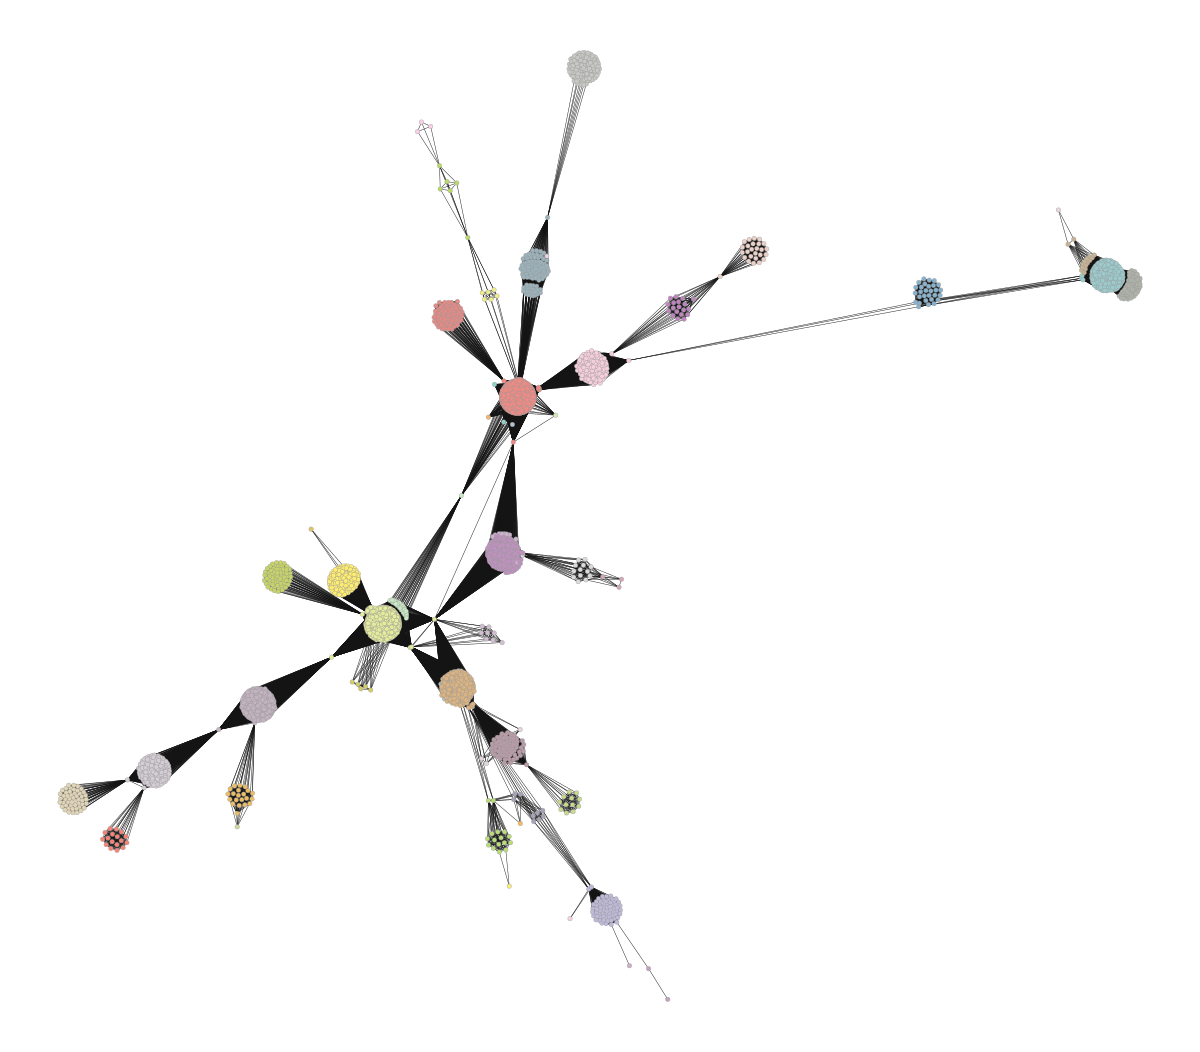

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc76848bc50, at 0x7fc76f9c94d0>

In [22]:
drawBuckets(bucketMap)

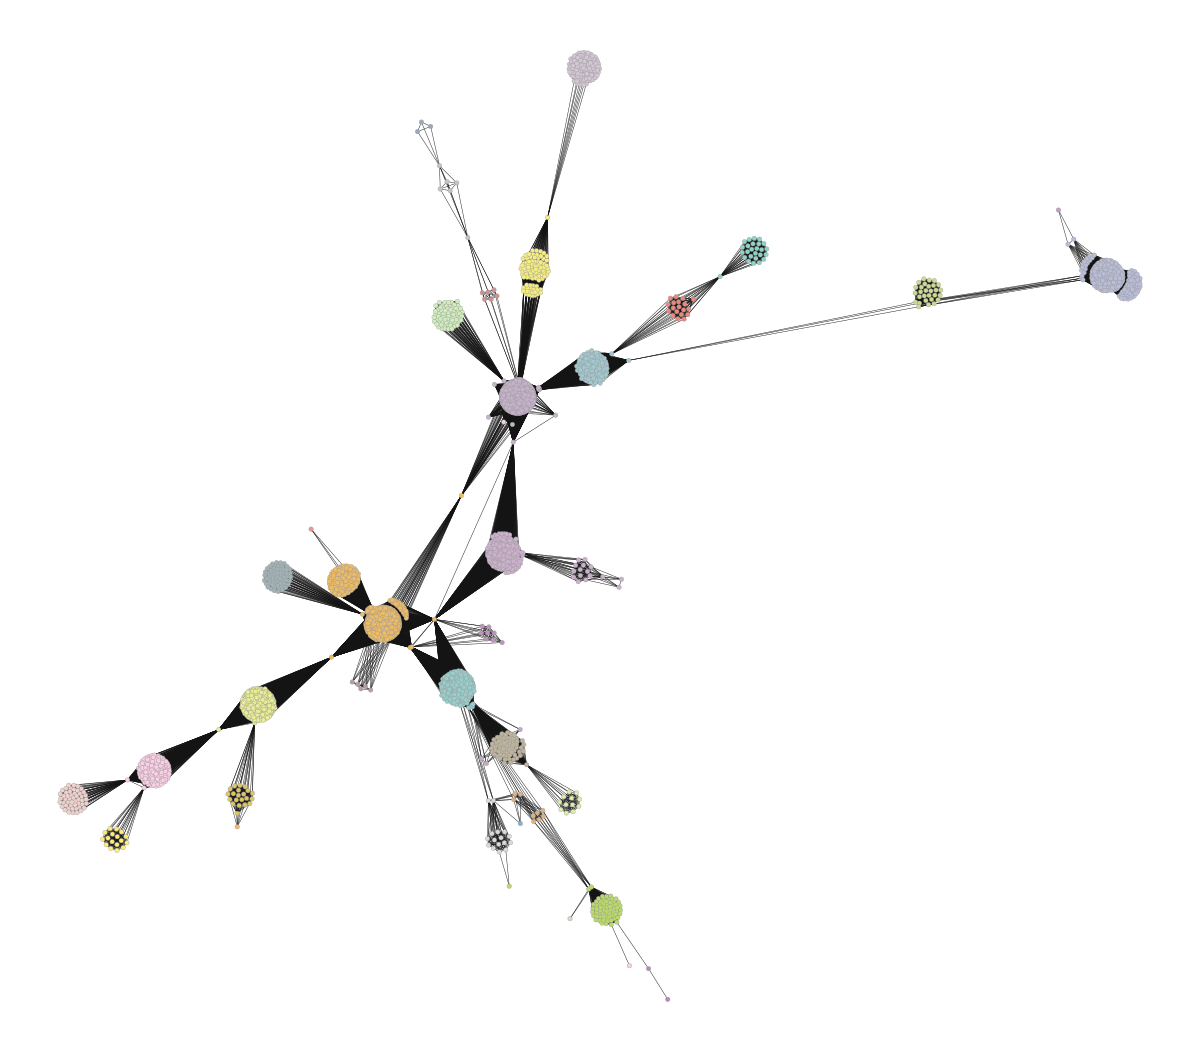

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc76848bc50, at 0x7fc76900e610>

In [23]:
drawBuckets(bucketSetMap)